In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "ibm-hr-analytics-attrition-dataset"

# Content
* [Part0:Introduction](#section-one)
* [Part1:Data Preprocessing](#section-two)
    - [Import the Data and Necessary Libraries](#2.1)
    - [Checking the missing value](#2.2)
    - [Clean useless data](#2.3)
* [Part 2:EDA (Exploratory Data Analysis)](#3.1)
    - [Attrition analysis](#3.2)
* [Part 3:Feature Engineering](#4.1)
    - [Derive job hop index](#4.2)
* [Part 4:Predicting Employee Churn](#5.1)
    - [Split the data](#5.2)
    - [Dealing with multicollinearity](#5.3)
    - [Logistic Model](#5.4)
    - [Random Forest](#5.5)
    - [Decision Tree](#5.6)
    - [Draw the ROC curves using test sample](#5.7)
    - [Logistic Model is the Best](#5.8)
    - [89.12% Accuracy and 83% AUC!!!! ](#5.9)
* [Part 5:Designing retention strategy](#6.1)
    - [Know who may leave](#6.2)
    - [Creating turnover risk bucket](#6.3)
    - [Retention Strategy](#6.4)

<a id="section-one"></a>
# Part0:Introduction

Employee Attrition is when employees end their formal relationship with an organization. In other words, attrition is the gradual loss or withdrawal of employees from an organization over a period of time. Employees are arguably the most important asset of any organization, and one of the most critical issues facing organizations today is how to retain their employees. Nearly a quarter of U.S. workers quit each year, and in some industries, the turnover rate is much higher. According to a study by **SHRM (Society for Human Resource Management)**, the cost of replacing an employee is 50-60% of that employee's salary, with overall costs ranging from 90% to 200%. In this project, I will use **IBM HR Analytics Employee Attrition & Performance Data(https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset?datasetId=1067&sortBy=voteCount&language=R)** to predict which employees are most likely to leave and use that information to design interventions to retain them.

<a id="section-two"></a>
# Part1:Data Preprocessing

<a id="2.1"></a>
## Import the Data and Necessary Libraries

In [2]:
library(dplyr)
library(ggplot2)
library(gridExtra)
library(Information)
library(caret)
install.packages("car",lib='/kaggle/working')
library("car",lib="/kaggle/working")
library(fastDummies) 
library(rpart) #cart decision tree
library(ranger) #random forest
library(caret) #very useful tuning tool for machine learning models
library(MLmetrics) # compute performance measures such as AUC and MSE
library(plotROC) # ggplot for ROC/Gains


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress


also installing the dependencies ‘nloptr’, ‘pbkrtest’, ‘lme4’


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Attaching package: ‘MLmetrics’


The following objects are masked from ‘package:caret’:

    MAE, RMSE


The following object is masked from ‘package:base’:

    Recall




In [3]:
library(caret)

In [4]:
IBM <- read.csv("../input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")
head(IBM)
glimpse(IBM)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6


Rows: 1,470
Columns: 35
$ Age                      <int> 41, 49, 37, 33, 27, 32, 59, 30, 38, 36, 35, 2…
$ Attrition                <chr> "Yes", "No", "Yes", "No", "No", "No", "No", "…
$ BusinessTravel           <chr> "Travel_Rarely", "Travel_Frequently", "Travel…
$ DailyRate                <int> 1102, 279, 1373, 1392, 591, 1005, 1324, 1358,…
$ Department               <chr> "Sales", "Research & Development", "Research …
$ DistanceFromHome         <int> 1, 8, 2, 3, 2, 2, 3, 24, 23, 27, 16, 15, 26, …
$ Education                <int> 2, 1, 2, 4, 1, 2, 3, 1, 3, 3, 3, 2, 1, 2, 3, …
$ EducationField           <chr> "Life Sciences", "Life Sciences", "Other", "L…
$ EmployeeCount            <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ EmployeeNumber           <int> 1, 2, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16,…
$ EnvironmentSatisfaction  <int> 2, 3, 4, 4, 1, 4, 3, 4, 4, 3, 1, 4, 1, 2, 3, …
$ Gender                   <chr> "Female", "Male", "Male", "Female", "Male", "…
$ HourlyRate    

<a id="2.2"></a>
## Checking the missing value

In [5]:
# Checking the missing value
sapply(IBM, function(x) sum(is.na(x)))

Age                Attrition           BusinessTravel 
                       0                        0                        0 
               DailyRate               Department         DistanceFromHome 
                       0                        0                        0 
               Education           EducationField            EmployeeCount 
                       0                        0                        0 
          EmployeeNumber  EnvironmentSatisfaction                   Gender 
                       0                        0                        0 
              HourlyRate           JobInvolvement                 JobLevel 
                       0                        0                        0 
                 JobRole          JobSatisfaction            MaritalStatus 
                       0                        0                        0 
           MonthlyIncome              MonthlyRate       NumCompaniesWorked 
                       0                        0                        0 
                  Over18                 OverTime        PercentSalaryHike 
                       0                        0                        0 
       PerformanceRating RelationshipSatisfaction            StandardHours 
                       0                        0                        0 
        StockOptionLevel        TotalWorkingYears    TrainingTimesLastYear 
                       0                        0                        0 
         WorkLifeBalance           YearsAtCompany       YearsInCurrentRole 
                       0                        0                        0 
 YearsSinceLastPromotion     YearsWithCurrManager 
                       0                        0

<a id="2.3"></a>
## Clean useless data

We should drop the attributes EmployeeNumber, Over18, EmployeeCount and StandardHours,because they all carry the same value for each row

In [6]:
#Drop EmployeeNumber, Over18, EmployeeCount and StandardHours
IBM$EmployeeCount <- NULL
IBM$Over18 <- NULL
IBM$StandardHours <- NULL
IBM$EmployeeNumber <-NULL
head(IBM)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,⋯,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,⋯,3,1,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,⋯,4,4,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,⋯,3,2,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,⋯,3,3,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,⋯,3,4,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,4,Male,⋯,3,3,0,8,2,2,7,7,3,6


<a id="3.1"></a>
# Part 2 :EDA (Exploratory Data Analysis)

In [7]:
IBM %>%
  count(Attrition)

# Calculate turnover rate
IBM$Turnover <-ifelse(IBM$Attrition == 'Yes',1,0)

IBM %>%
summarize(Turnover_level = mean(Turnover))

Attrition,n
<chr>,<int>
No,1233
Yes,237


Turnover_level
<dbl>
0.1612245


<a id="3.2"></a>
## Attrition analysis

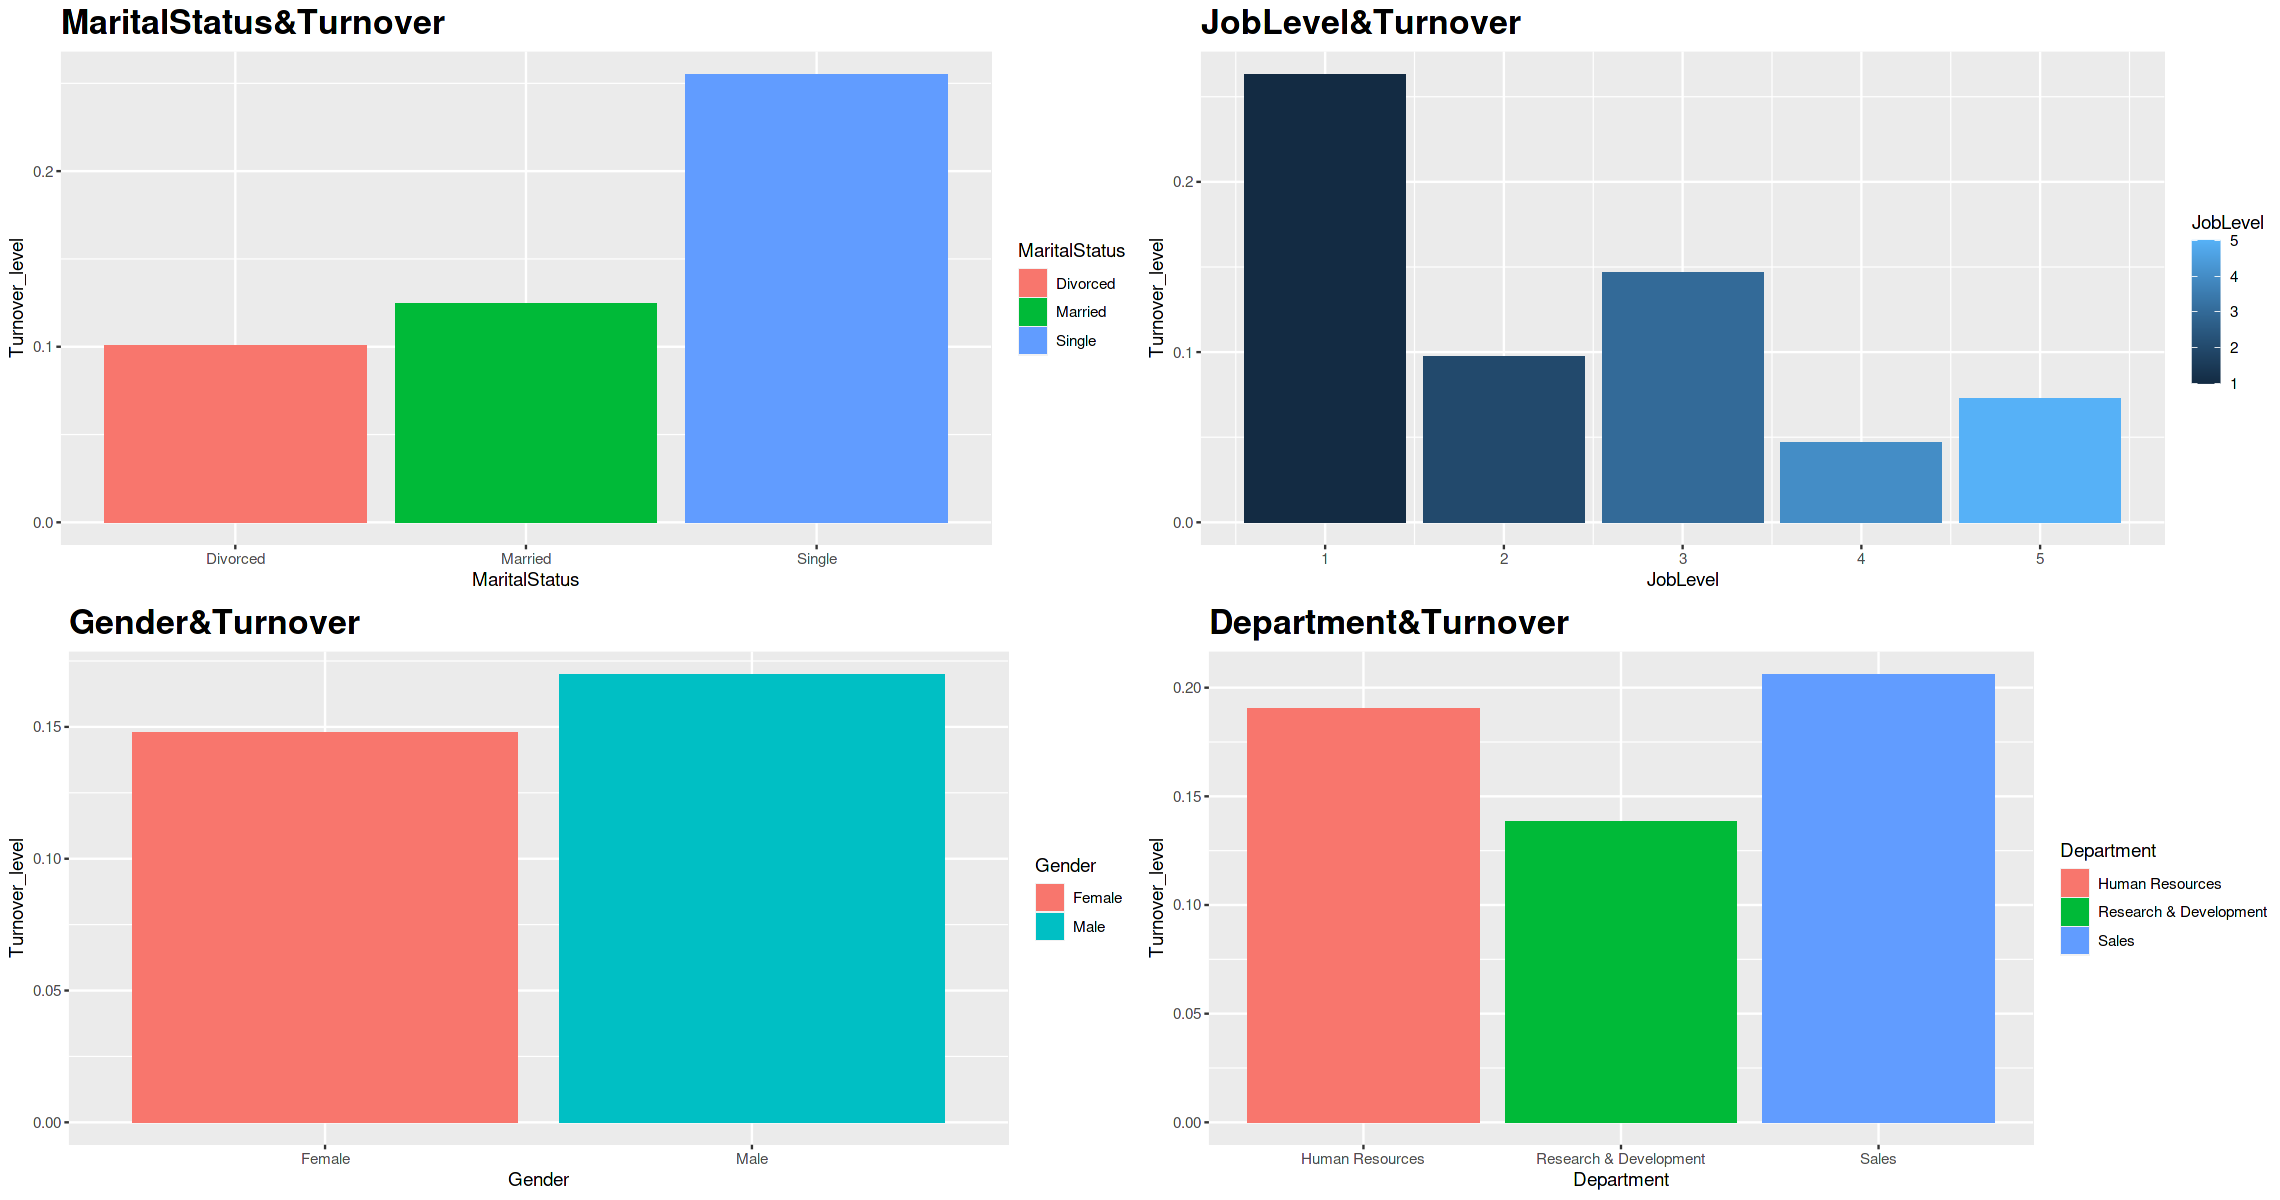

In [8]:
fig <- function(w, h){
     options(repr.plot.width = w, repr.plot.height = h)
}
fig(19,10)
#Married with Turnover
IBM_Married <- IBM %>%
  group_by(MaritalStatus) %>%
  summarize(Turnover_level = mean(Turnover))

 M_T <- ggplot(IBM_Married, aes(x = MaritalStatus, y = Turnover_level,fill=MaritalStatus)) + 
  geom_col() +ggtitle("MaritalStatus&Turnover") + 
theme(plot.title = element_text(size = 20, face = "bold"))
#JobLevel with Turnover
IBM_level <- IBM %>%
  group_by(JobLevel) %>%
  summarize(Turnover_level = mean(Turnover))

Job_T <- ggplot(IBM_level, aes(x = JobLevel, y = Turnover_level,fill=JobLevel)) + 
  geom_col()+ggtitle("JobLevel&Turnover") + 
theme(plot.title = element_text(size = 20, face = "bold"))
#Gender with Turnover
IBM_Gender <- IBM %>%
  group_by(Gender) %>%
  summarize(Turnover_level = mean(Turnover))

G_T <- ggplot(IBM_Gender, aes(x = Gender, y = Turnover_level,fill=Gender)) + 
  geom_col()+ggtitle("Gender&Turnover") + 
theme(plot.title = element_text(size = 20, face = "bold"))
#Department with Turnover
IBM_Depart <- IBM %>%
  group_by(Department) %>%
  summarize(Turnover_level = mean(Turnover))

D_T <- ggplot(IBM_Depart, aes(x = Department, y = Turnover_level,fill=Department)) + 
  geom_col()+ggtitle("Department&Turnover") + 
theme(plot.title = element_text(size = 20, face = "bold"))

grid.arrange(M_T,Job_T,G_T,D_T, ncol = 2, nrow = 2)

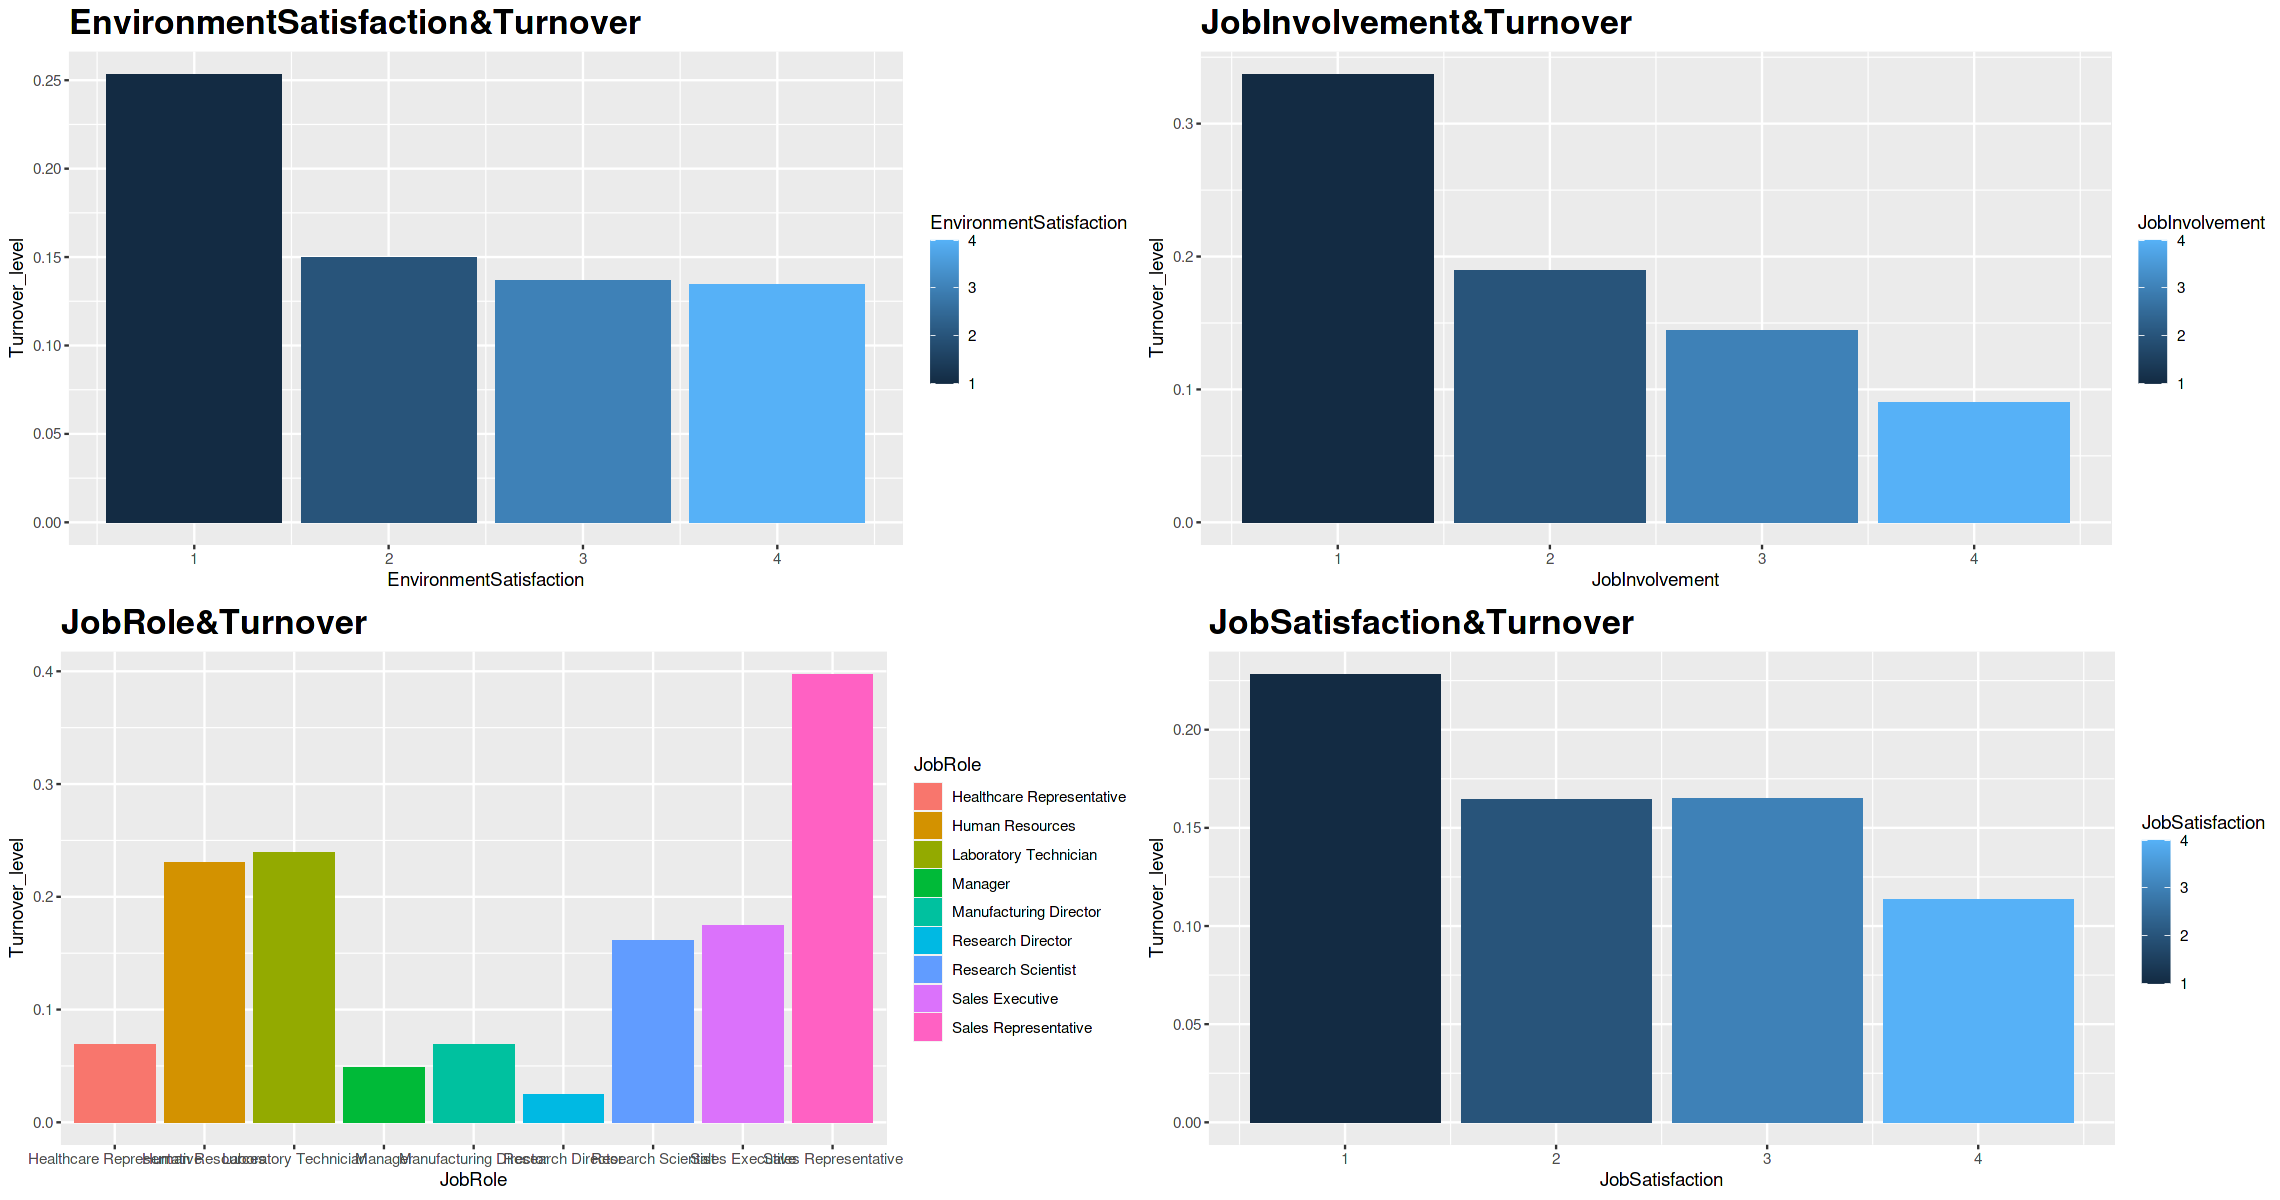

In [9]:
#EnvironmentSatisfaction with Turnover
IBM_EnvironmentSatisfaction <- IBM %>%
  group_by(EnvironmentSatisfaction) %>%
  summarize(Turnover_level = mean(Turnover))

 EnvironmentSatisfaction_T <- ggplot(IBM_EnvironmentSatisfaction, aes(x = EnvironmentSatisfaction, y = Turnover_level,fill=EnvironmentSatisfaction)) + 
  geom_col() +ggtitle("EnvironmentSatisfaction&Turnover") + 
theme(plot.title = element_text(size = 20, face = "bold"))
#JobInvolvement with Turnover
IBM_JobInvolvement <- IBM %>%
  group_by(JobInvolvement) %>%
  summarize(Turnover_level = mean(Turnover))

JobInvolvement_T <- ggplot(IBM_JobInvolvement, aes(x = JobInvolvement, y = Turnover_level,fill=JobInvolvement)) + 
  geom_col()+ggtitle("JobInvolvement&Turnover") + 
theme(plot.title = element_text(size = 20, face = "bold"))
#JobRole with Turnover
IBM_JobRole <- IBM %>%
  group_by(JobRole) %>%
  summarize(Turnover_level = mean(Turnover))

JobRole_T <- ggplot(IBM_JobRole, aes(x = JobRole, y = Turnover_level,fill=JobRole)) + 
  geom_col()+ggtitle("JobRole&Turnover") + 
theme(plot.title = element_text(size = 20, face = "bold"))
#Department with Turnover
IBM_JobSatisfaction <- IBM %>%
  group_by(JobSatisfaction) %>%
  summarize(Turnover_level = mean(Turnover))

JobSatisfaction_T <- ggplot(IBM_JobSatisfaction, aes(x = JobSatisfaction, y = Turnover_level,fill=JobSatisfaction)) + 
  geom_col()+ggtitle("JobSatisfaction&Turnover") + 
theme(plot.title = element_text(size = 20, face = "bold"))

grid.arrange(EnvironmentSatisfaction_T,JobInvolvement_T,JobRole_T ,JobSatisfaction_T, ncol = 2, nrow = 2)

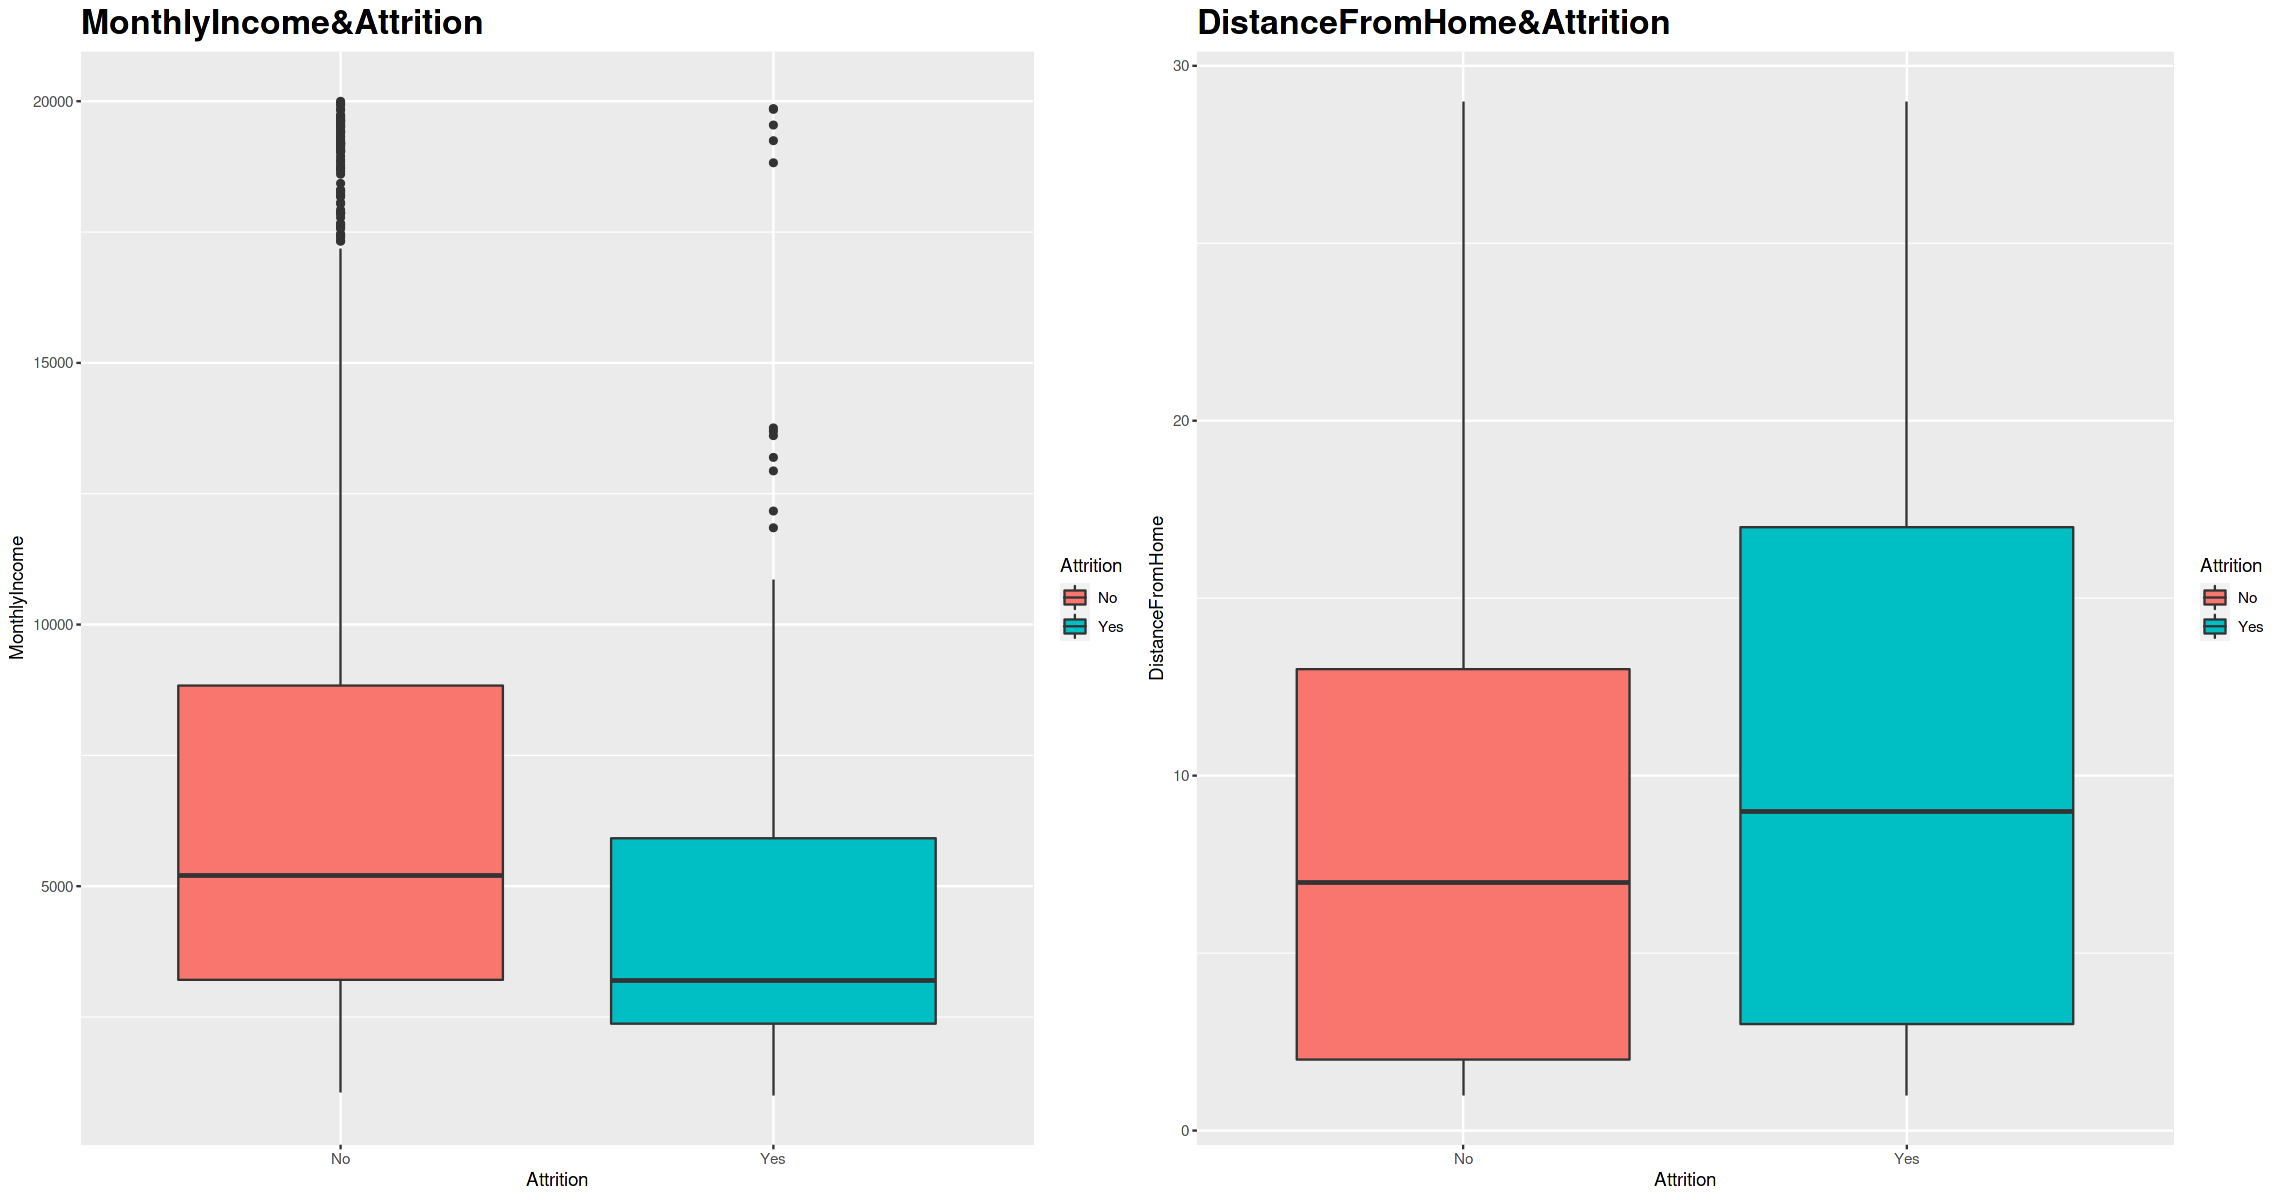

In [10]:
fig(19,10)
#MonthlyIncome with Attrition
 M_A <- ggplot(IBM, aes(x = Attrition, y = MonthlyIncome,fill=Attrition)) + 
  geom_boxplot() +ggtitle("MonthlyIncome&Attrition") + 
theme(plot.title = element_text(size = 20, face = "bold"))

#DistanceFromHome with Attrition
 M_D <- ggplot(IBM, aes(x = Attrition, y = DistanceFromHome,fill=Attrition)) + 
  geom_boxplot() +ggtitle("DistanceFromHome&Attrition") + 
theme(plot.title = element_text(size = 20, face = "bold"))


grid.arrange(M_A,M_D, ncol = 2, nrow = 1)

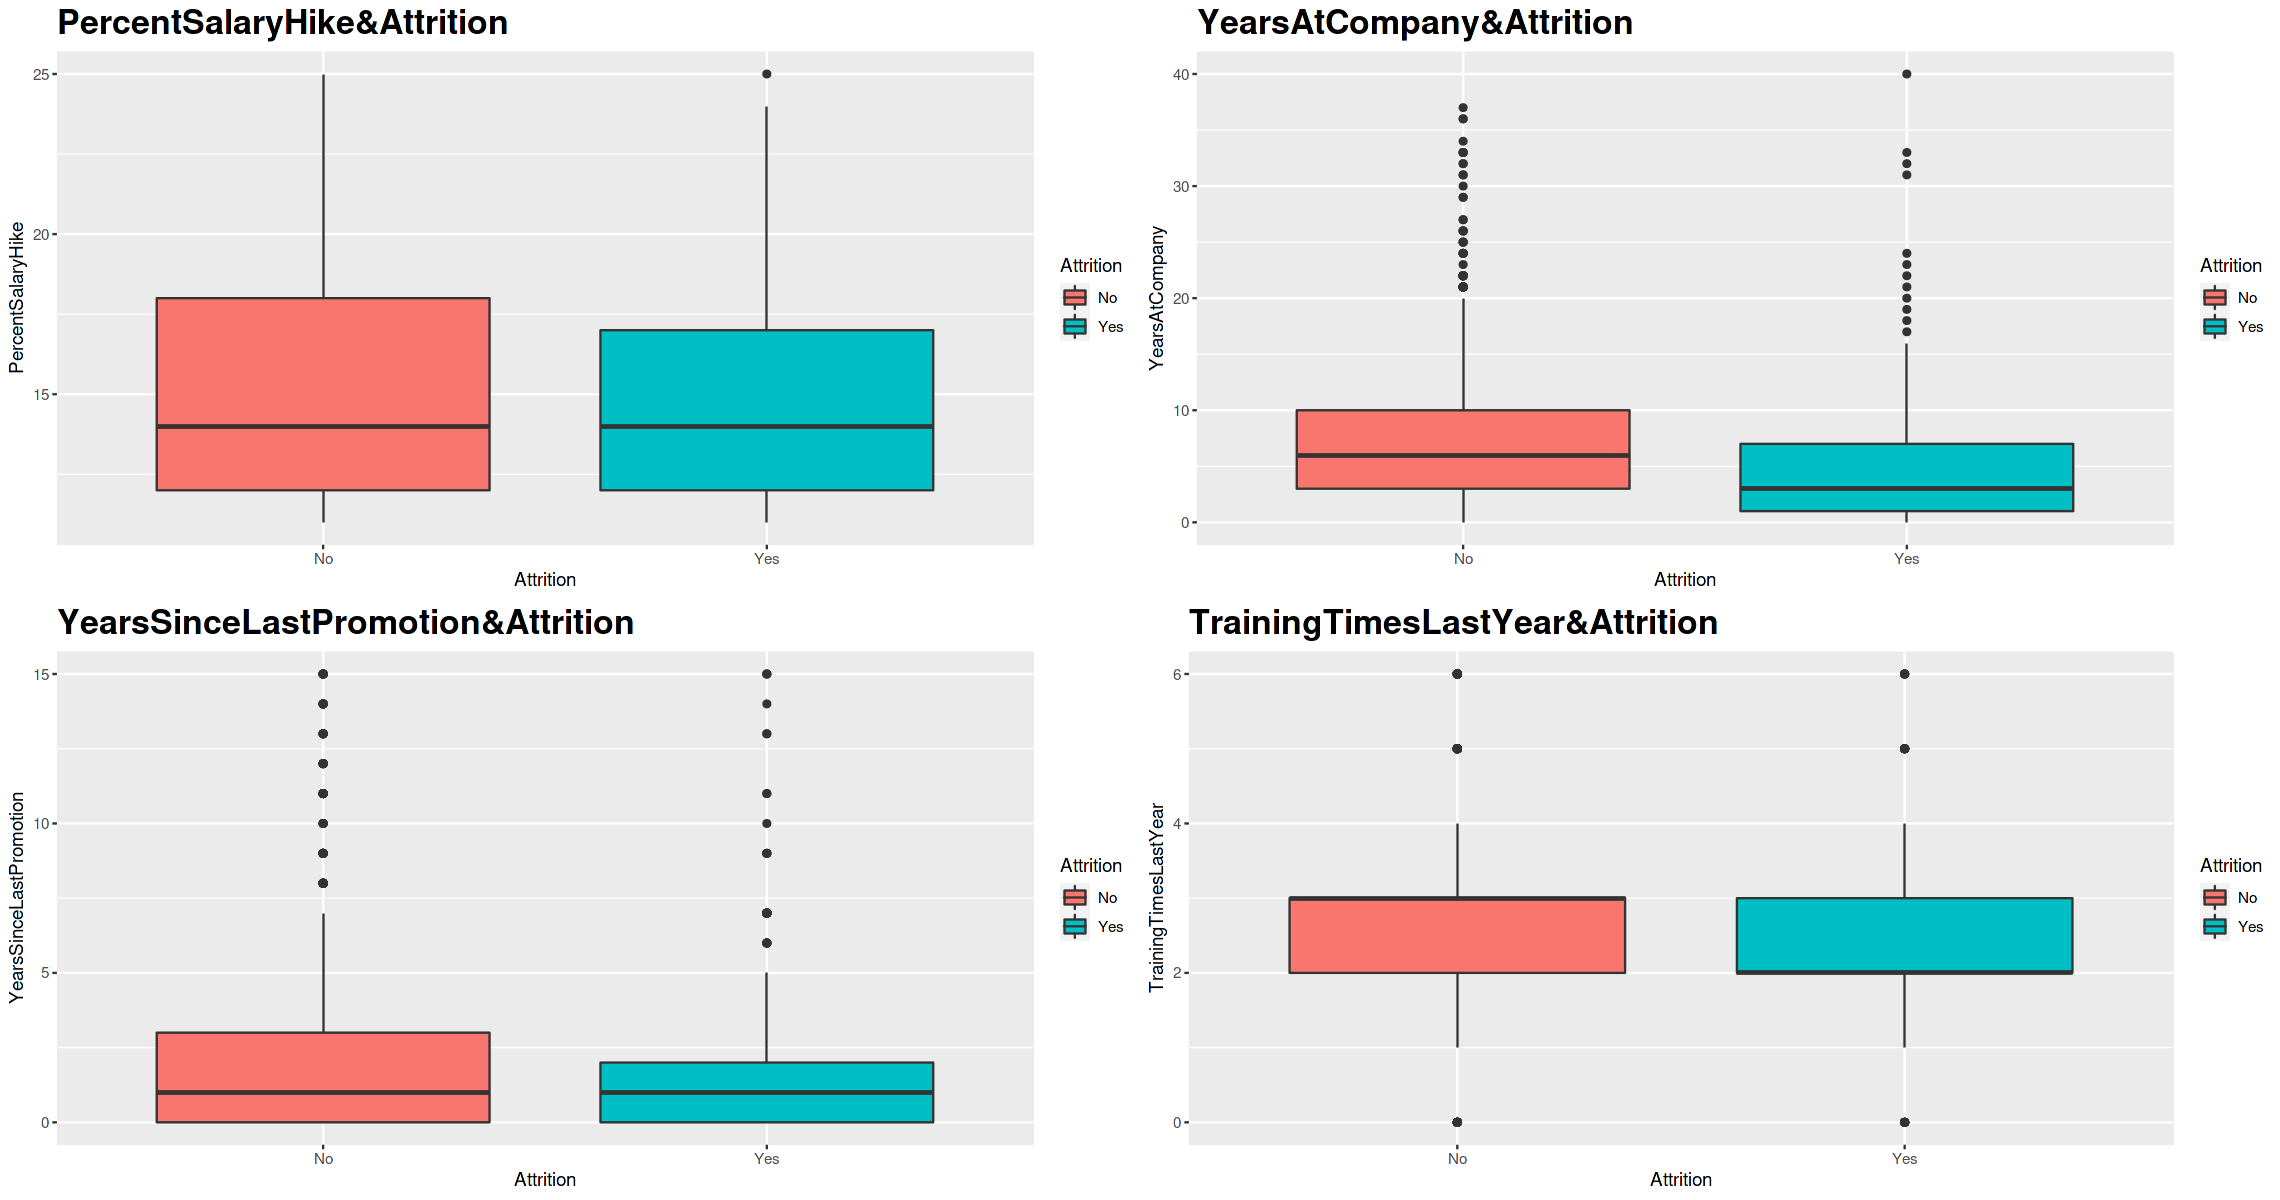

In [11]:
fig(19,10)
#PercentSalaryHike with Attrition
 A <- ggplot(IBM, aes(x = Attrition, y = PercentSalaryHike,fill=Attrition)) + 
  geom_boxplot() +ggtitle("PercentSalaryHike&Attrition") + 
theme(plot.title = element_text(size = 20, face = "bold"))

#YearsAtCompany with Attrition
 B <- ggplot(IBM, aes(x = Attrition, y = YearsAtCompany,fill=Attrition)) + 
  geom_boxplot() +ggtitle("YearsAtCompany&Attrition") + 
theme(plot.title = element_text(size = 20, face = "bold"))

 C <- ggplot(IBM, aes(x = Attrition, y = YearsSinceLastPromotion,fill=Attrition)) + 
  geom_boxplot() +ggtitle("YearsSinceLastPromotion&Attrition") + 
theme(plot.title = element_text(size = 20, face = "bold"))

D <- ggplot(IBM, aes(x = Attrition, y = TrainingTimesLastYear,fill=Attrition)) + 
  geom_boxplot() +ggtitle("TrainingTimesLastYear&Attrition") + 
theme(plot.title = element_text(size = 20, face = "bold"))

grid.arrange(A,B,C,D, ncol = 2, nrow = 2)

<a id="4.1"></a>
# Feature Engineering

<a id="4.2"></a>
## Derive job hop index
A job hopper is a person who switches jobs frequently for financial or career advancement opportunities. In some industries, recruiters and hiring managers may perceive job hoppers in a negative light and think they are unstable or disloyal employees.

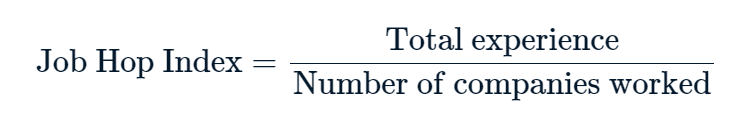

Total experience **(TotalWorkingYears**) and the number of companies worked (**NumCompaniesWorked+1**) are available in IBM.

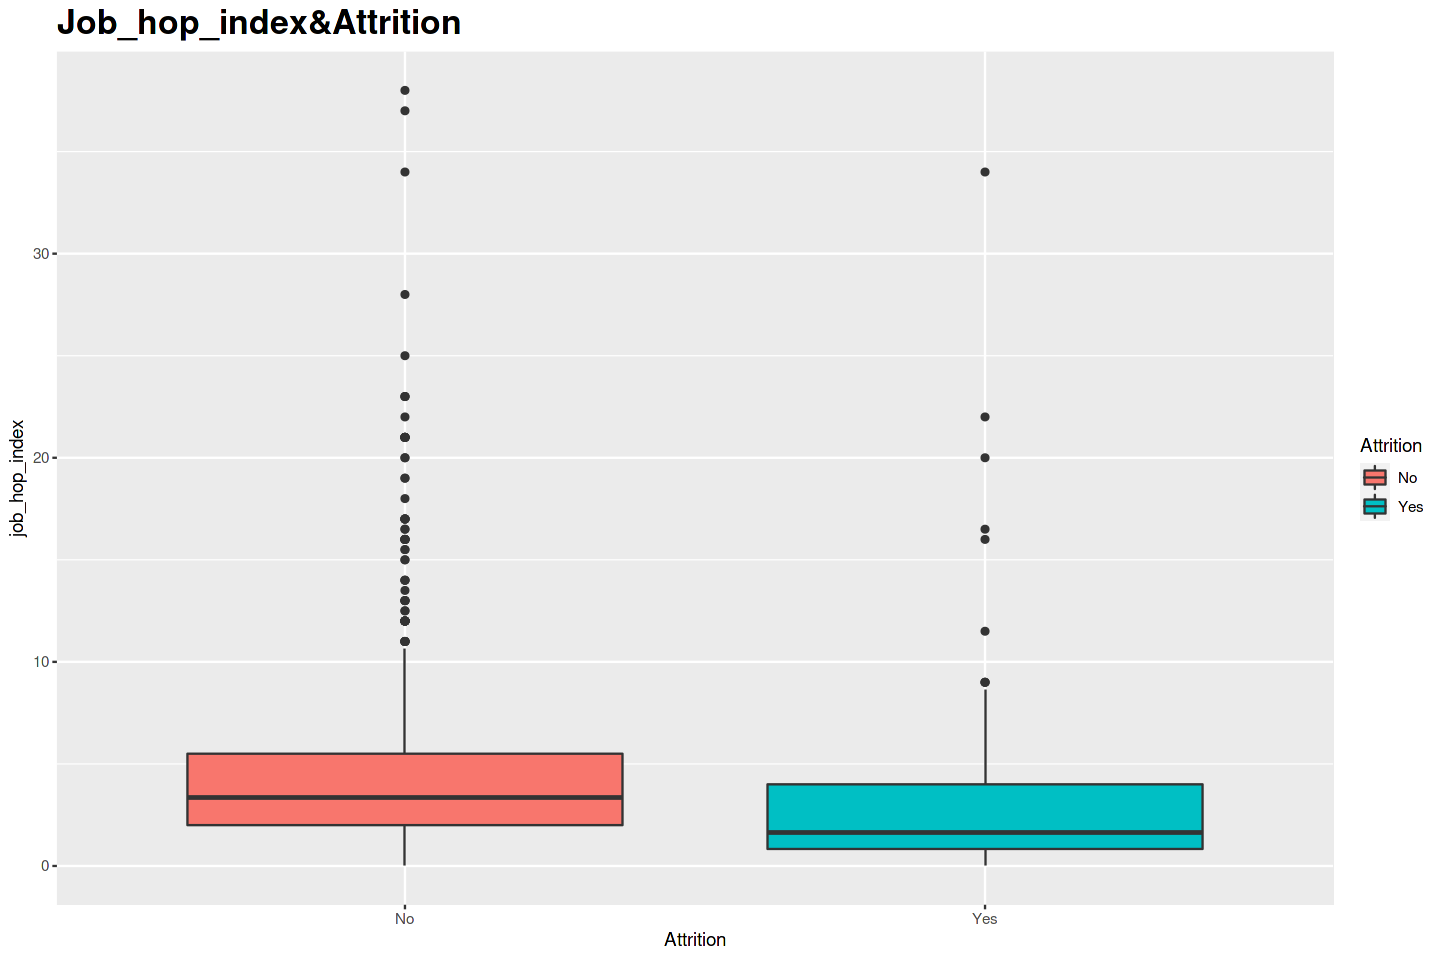

In [12]:
fig(12,8)
# Add job hop index
IBM$job_hop_index <- IBM$TotalWorkingYears/(IBM$NumCompaniesWorked+1)

# Compare job hopping index with Attrition
ggplot(IBM, aes(x = Attrition, y = job_hop_index,fill=Attrition)) + 
  geom_boxplot()+ggtitle("Job_hop_index&Attrition") + 
theme(plot.title = element_text(size = 20, face = "bold"))

In [13]:
# Changing the datatype from integer to factors from the ordinal variables.

IBM$Education <- factor(IBM$Education)
IBM$EnvironmentSatisfaction <- factor(IBM$EnvironmentSatisfaction)
IBM$JobInvolvement <- factor(IBM$JobInvolvement)
IBM$JobLevel <- factor(IBM$JobLevel)
IBM$JobSatisfaction <- factor(IBM$JobSatisfaction)
IBM$PerformanceRating <- factor(IBM$PerformanceRating)
IBM$RelationshipSatisfaction <- factor(IBM$RelationshipSatisfaction)
IBM$StockOptionLevel <- factor(IBM$StockOptionLevel)
IBM$WorkLifeBalance <- factor(IBM$WorkLifeBalance)

In [14]:
glimpse(IBM)

Rows: 1,470
Columns: 33
$ Age                      <int> 41, 49, 37, 33, 27, 32, 59, 30, 38, 36, 35, 2…
$ Attrition                <chr> "Yes", "No", "Yes", "No", "No", "No", "No", "…
$ BusinessTravel           <chr> "Travel_Rarely", "Travel_Frequently", "Travel…
$ DailyRate                <int> 1102, 279, 1373, 1392, 591, 1005, 1324, 1358,…
$ Department               <chr> "Sales", "Research & Development", "Research …
$ DistanceFromHome         <int> 1, 8, 2, 3, 2, 2, 3, 24, 23, 27, 16, 15, 26, …
$ Education                <fct> 2, 1, 2, 4, 1, 2, 3, 1, 3, 3, 3, 2, 1, 2, 3, …
$ EducationField           <chr> "Life Sciences", "Life Sciences", "Other", "L…
$ EnvironmentSatisfaction  <fct> 2, 3, 4, 4, 1, 4, 3, 4, 4, 3, 1, 4, 1, 2, 3, …
$ Gender                   <chr> "Female", "Male", "Male", "Female", "Male", "…
$ HourlyRate               <int> 94, 61, 92, 56, 40, 79, 81, 67, 44, 94, 84, 4…
$ JobInvolvement           <fct> 3, 2, 2, 3, 3, 3, 4, 3, 2, 3, 4, 2, 3, 3, 2, …
$ JobLevel      

<a id="5.1"></a>
# Predicting Employee Churn

<a id="5.2"></a>
## Split the data

In [15]:
set.seed(1)

# Store row numbers for training dataset: index_train
IBM_train <- createDataPartition(IBM$Turnover, p = 0.7, list = FALSE)

# Create training dataset: train_set
train_set <- IBM[IBM_train, ]

# Create testing dataset: test_set
test_set <- IBM[-IBM_train, ]

In [16]:
train_set$Attrition <- NULL
train_set$TotalWorkingYears <- NULL
train_set$NumCompaniesWorked <- NULL

In [17]:
# Calculate turnover proportion in train_set
train_set %>% 
  count(Turnover) %>% 
  mutate(prop = n / sum(n))

# Calculate turnover proportion in test_set
test_set %>% 
  count(Turnover) %>% 
  mutate(prop = n / sum(n))

Turnover,n,prop
<dbl>,<int>,<dbl>
0,862,0.8377065
1,167,0.1622935


Turnover,n,prop
<dbl>,<int>,<dbl>
0,371,0.8412698
1,70,0.1587302


<a id="5.3"></a>
## Dealing with multicollinearity
In the previous exercise, you found that multicollinearity exists in your model by reviewing the VIF values of independent variables. Follow the steps below to remove multicollinearity:

* Step 1: Calculate VIF of the model
* Step 2: Identify if any variable has VIF greater than or equal to 5
* Step 2a: Remove the variable from the model if it has a VIF greater than or equal to 5
* Step 2b: If there are multiple variables with VIF greater than 5, only remove the variable with the highest VIF
* Step 3: Repeat steps 1 and 2 until VIF of all variables is less than 5

In [18]:
glimpse(train_set)

Rows: 1,029
Columns: 30
$ Age                      <int> 41, 37, 27, 59, 30, 38, 31, 34, 28, 32, 53, 3…
$ BusinessTravel           <chr> "Travel_Rarely", "Travel_Rarely", "Travel_Rar…
$ DailyRate                <int> 1102, 1373, 591, 1324, 1358, 216, 670, 1346, …
$ Department               <chr> "Sales", "Research & Development", "Research …
$ DistanceFromHome         <int> 1, 2, 2, 3, 24, 23, 26, 19, 24, 5, 2, 2, 11, …
$ Education                <fct> 2, 2, 1, 3, 1, 3, 1, 2, 3, 2, 4, 3, 2, 4, 4, …
$ EducationField           <chr> "Life Sciences", "Other", "Medical", "Medical…
$ EnvironmentSatisfaction  <fct> 2, 4, 1, 3, 4, 4, 1, 2, 3, 1, 1, 4, 1, 3, 1, …
$ Gender                   <chr> "Female", "Male", "Male", "Female", "Male", "…
$ HourlyRate               <int> 94, 92, 40, 81, 67, 44, 31, 93, 50, 80, 78, 4…
$ JobInvolvement           <fct> 3, 2, 3, 4, 3, 2, 3, 3, 2, 4, 2, 3, 4, 2, 3, …
$ JobLevel                 <fct> 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 4, 1, 2, 1, 3, …
$ JobRole       

In [19]:
logmodel <- glm(Turnover ~., family=binomial(link="logit"), data = train_set)
summary(logmodel)


Call:
glm(formula = Turnover ~ ., family = binomial(link = "logit"), 
    data = train_set)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8818  -0.4267  -0.1866  -0.0455   3.9075  

Coefficients:
                                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      -1.266e+01  7.589e+02  -0.017 0.986688    
Age                              -2.791e-02  1.517e-02  -1.840 0.065814 .  
BusinessTravelTravel_Frequently   2.137e+00  5.305e-01   4.028 5.63e-05 ***
BusinessTravelTravel_Rarely       1.008e+00  4.817e-01   2.093 0.036387 *  
DailyRate                        -5.858e-04  2.935e-04  -1.996 0.045912 *  
DepartmentResearch & Development  1.681e+01  7.589e+02   0.022 0.982326    
DepartmentSales                   1.634e+01  7.589e+02   0.022 0.982820    
DistanceFromHome                  5.937e-02  1.442e-02   4.117 3.84e-05 ***
Education2                       -1.882e-02  4.224e-01  -0.045 0.964467    
Education3        

In [20]:
print(vif(logmodel))

                                 GVIF Df GVIF^(1/(2*Df))
Age                      1.498041e+00  1        1.223945
BusinessTravel           1.379556e+00  2        1.083764
DailyRate                1.137105e+00  1        1.066351
Department               9.292892e+07  2       98.183322
DistanceFromHome         1.188590e+00  1        1.090225
Education                1.740732e+00  4        1.071745
EducationField           4.636244e+00  5        1.165780
EnvironmentSatisfaction  1.557232e+00  3        1.076611
Gender                   1.159059e+00  1        1.076596
HourlyRate               1.157785e+00  1        1.076004
JobInvolvement           1.407933e+00  3        1.058677
JobLevel                 8.674080e+01  4        1.746940
JobRole                  2.549839e+09  8        3.871748
JobSatisfaction          1.347961e+00  3        1.051025
MaritalStatus            3.324085e+00  2        1.350262
MonthlyIncome            1.593740e+01  1        3.992167
MonthlyRate              1.1396

In [21]:
train_set <- subset(train_set, select = - c(Department))
test_set <- subset(test_set, select = - c(Department))

In [22]:
logmodel1 <- glm(Turnover ~., family=binomial(link="logit"), data = train_set)
print(vif(logmodel1))

                              GVIF Df GVIF^(1/(2*Df))
Age                       1.493594  1        1.222127
BusinessTravel            1.373971  2        1.082666
DailyRate                 1.128211  1        1.062173
DistanceFromHome          1.183881  1        1.088063
Education                 1.710647  4        1.069412
EducationField            3.724096  5        1.140518
EnvironmentSatisfaction   1.538222  3        1.074409
Gender                    1.156794  1        1.075544
HourlyRate                1.146025  1        1.070525
JobInvolvement            1.404339  3        1.058227
JobLevel                 83.977556  4        1.739884
JobRole                  83.884066  8        1.318955
JobSatisfaction           1.346068  3        1.050778
MaritalStatus             3.251706  2        1.342851
MonthlyIncome            15.980399  1        3.997549
MonthlyRate               1.134982  1        1.065355
OverTime                  1.338608  1        1.156982
PercentSalaryHike         2.

In [23]:
train_set <- subset(train_set, select = - c(JobRole))
test_set <- subset(test_set, select = - c(JobRole))

In [24]:
logmodel2 <- glm(Turnover ~., family=binomial(link="logit"), data = train_set)
print(vif(logmodel2))

                              GVIF Df GVIF^(1/(2*Df))
Age                       1.473995  1        1.214082
BusinessTravel            1.277245  2        1.063086
DailyRate                 1.075934  1        1.037273
DistanceFromHome          1.168313  1        1.080885
Education                 1.569881  4        1.057994
EducationField            1.772450  5        1.058906
EnvironmentSatisfaction   1.334484  3        1.049266
Gender                    1.116228  1        1.056517
HourlyRate                1.097926  1        1.047820
JobInvolvement            1.375626  3        1.054589
JobLevel                 23.565751  4        1.484346
JobSatisfaction           1.270667  3        1.040731
MaritalStatus             3.199519  2        1.337430
MonthlyIncome            12.284172  1        3.504878
MonthlyRate               1.090502  1        1.044271
OverTime                  1.235898  1        1.111710
PercentSalaryHike         2.818041  1        1.678702
PerformanceRating         2.

In [25]:
train_set <- subset(train_set, select = - c(JobLevel))
test_set <- subset(test_set, select = - c(JobLevel))

In [26]:
logmodel3 <- glm(Turnover ~., family=binomial(link="logit"), data = train_set)
print(vif(logmodel3))

                             GVIF Df GVIF^(1/(2*Df))
Age                      1.435064  1        1.197941
BusinessTravel           1.223903  2        1.051809
DailyRate                1.075102  1        1.036871
DistanceFromHome         1.133038  1        1.064443
Education                1.481493  4        1.050358
EducationField           1.607399  5        1.048606
EnvironmentSatisfaction  1.286873  3        1.042932
Gender                   1.100063  1        1.048839
HourlyRate               1.086991  1        1.042589
JobInvolvement           1.274614  3        1.041269
JobSatisfaction          1.259505  3        1.039202
MaritalStatus            3.199468  2        1.337425
MonthlyIncome            1.777510  1        1.333233
MonthlyRate              1.070503  1        1.034651
OverTime                 1.208590  1        1.099359
PercentSalaryHike        2.778077  1        1.666757
PerformanceRating        2.776685  1        1.666339
RelationshipSatisfaction 1.408064  3        1.

In [27]:
train_set <- subset(train_set, select = - c(YearsAtCompany))
test_set <- subset(test_set, select = - c(YearsAtCompany))

<a id="5.4"></a>
## Logistic Model

In [28]:
logmodel4 <- glm(Turnover ~., family=binomial(link="logit"), data = train_set)
print(vif(logmodel4))

                             GVIF Df GVIF^(1/(2*Df))
Age                      1.424139  1        1.193373
BusinessTravel           1.225525  2        1.052157
DailyRate                1.073273  1        1.035989
DistanceFromHome         1.132327  1        1.064109
Education                1.473051  4        1.049608
EducationField           1.567231  5        1.045956
EnvironmentSatisfaction  1.285763  3        1.042782
Gender                   1.099148  1        1.048403
HourlyRate               1.085971  1        1.042099
JobInvolvement           1.267249  3        1.040264
JobSatisfaction          1.252357  3        1.038217
MaritalStatus            3.172219  2        1.334568
MonthlyIncome            1.557370  1        1.247946
MonthlyRate              1.069366  1        1.034102
OverTime                 1.206288  1        1.098311
PercentSalaryHike        2.749209  1        1.658074
PerformanceRating        2.738112  1        1.654724
RelationshipSatisfaction 1.395374  3        1.

In [29]:
summary(logmodel4)


Call:
glm(formula = Turnover ~ ., family = binomial(link = "logit"), 
    data = train_set)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7009  -0.4722  -0.2585  -0.0841   4.6721  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      4.638e+00  1.470e+00   3.154 0.001610 ** 
Age                             -3.113e-02  1.416e-02  -2.198 0.027939 *  
BusinessTravelTravel_Frequently  1.898e+00  4.940e-01   3.842 0.000122 ***
BusinessTravelTravel_Rarely      9.445e-01  4.578e-01   2.063 0.039106 *  
DailyRate                       -4.562e-04  2.715e-04  -1.680 0.092948 .  
DistanceFromHome                 5.276e-02  1.324e-02   3.985 6.76e-05 ***
Education2                       7.336e-02  3.975e-01   0.185 0.853591    
Education3                      -9.877e-04  3.520e-01  -0.003 0.997761    
Education4                       2.111e-01  3.846e-01   0.549 0.583064    
Education5                  

In [30]:
prediction_test <- predict(logmodel4, newdata = test_set, 
                            type = "response")

<a id="5.5"></a>
## Random forest 

In [31]:
ranger.caret <- train(as.factor(Turnover) ~.,
                        data = train_set, method="ranger", 
                       trControl = trainControl(method = "cv", number = 10))
ranger.caret

Random Forest 

1029 samples
  25 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 927, 927, 925, 925, 926, 926, ... 
Resampling results across tuning parameters:

  mtry  splitrule   Accuracy   Kappa     
   2    gini        0.8435502  0.05724781
   2    extratrees  0.8377246  0.00000000
  24    gini        0.8609798  0.26649075
  24    extratrees  0.8561628  0.21367239
  46    gini        0.8512610  0.23815460
  46    extratrees  0.8522509  0.21876936

Tuning parameter 'min.node.size' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were mtry = 24, splitrule = gini
 and min.node.size = 1.

In [32]:
IBM.ranger <- ranger(as.factor(Turnover) ~.,data = train_set, probability = TRUE, mtry = 24, splitrule = "gini", min.node.size = 1)

In [33]:
ranger.predict.train <- predict(IBM.ranger, data = train_set, type = "response")
ranger.predict.test <- predict(IBM.ranger, data = test_set, type = "response")
# AUC
AUC(ranger.predict.test$predictions[,2], test_set$Turnover)

[1] 0.7803427

<a id="5.6"></a>
## Decision Tree

In [34]:
cart.caret <- train(as.factor(Turnover) ~ .,
                        data = train_set, method="rpart",
                       trControl = trainControl(method = "cv", number = 10))
cart.caret

CART 

1029 samples
  25 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 927, 926, 926, 926, 925, 926, ... 
Resampling results across tuning parameters:

  cp          Accuracy   Kappa     
  0.02694611  0.8503494  0.22380505
  0.04191617  0.8445429  0.12426895
  0.04491018  0.8386986  0.04471829

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.02694611.

In [35]:
IBM.cart <- rpart(Turnover ~.,
                       method="class",
                       data = train_set, 
                       control = rpart.control(cp = 0.02694611))

cart.predict.train <- predict(IBM.cart, newdata = train_set)
cart.predict.test <- predict(IBM.cart, newdata = test_set)

# AUC for test sample
AUC(cart.predict.test[,2], test_set$Turnover)

[1] 0.6119946

<a id="5.7"></a>
## Draw the ROC curves using test sample

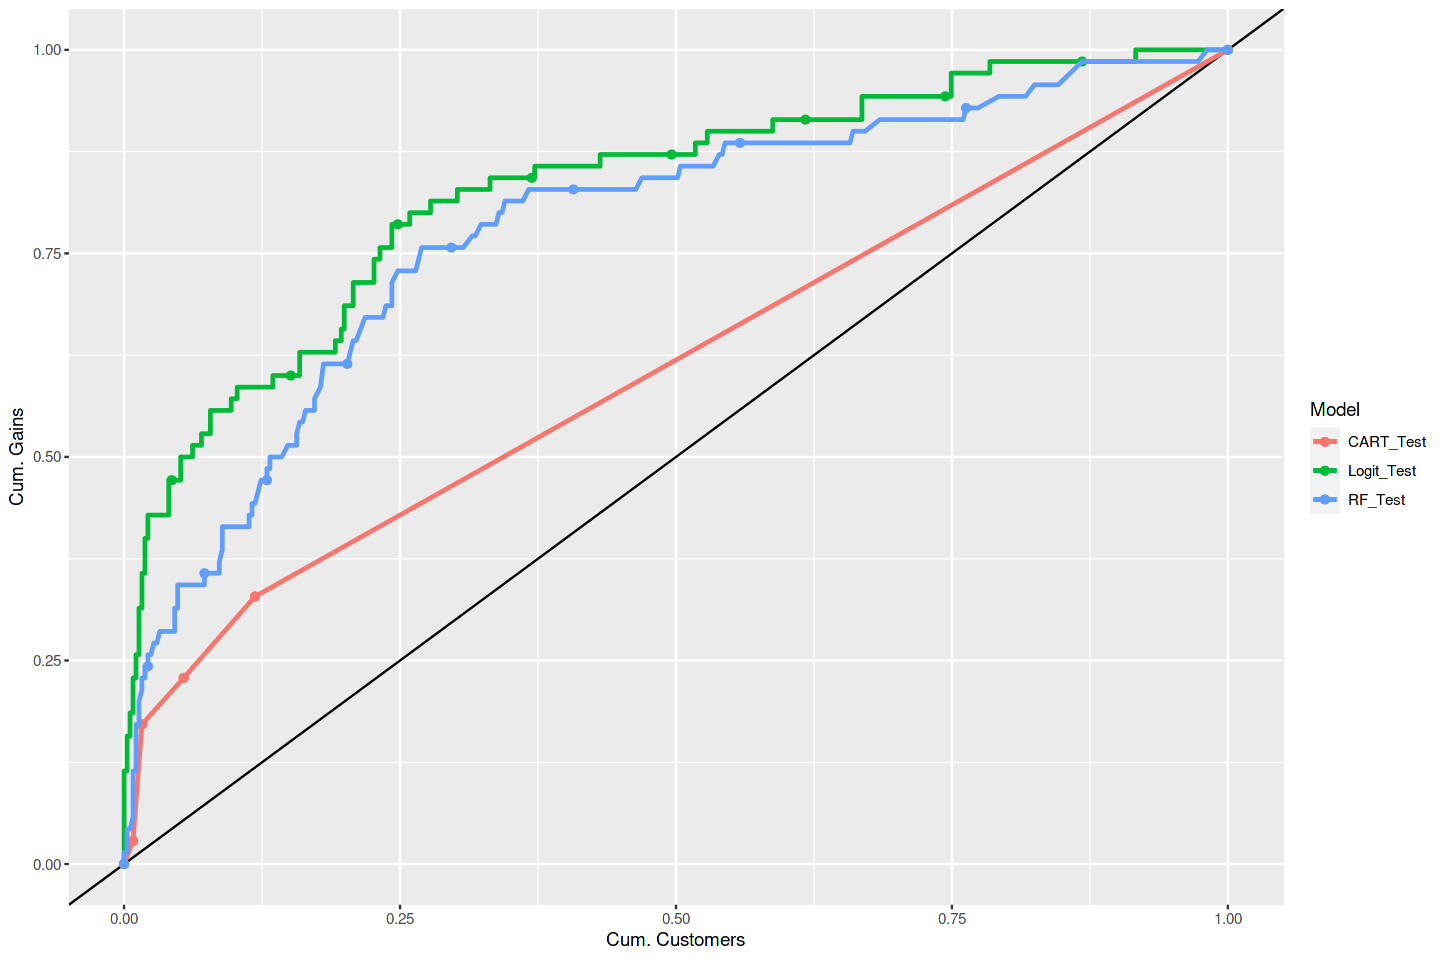

In [36]:
plotdata.test <- data.frame(cbind(test_set$Turnover,
                                   prediction_test,
                                   cart.predict.test[,2],
                                   ranger.predict.test$predictions[,2]))
names(plotdata.test) <- c("Turnover", "Logit", "CART", "RF")

comparison.plot <- ggplot(plotdata.test, aes(m = Logit, d = Turnover))+ 
  geom_roc(labels=FALSE, aes(color = 'Logit_Test')) +
  labs(x = "Cum. Customers", y = "Cum. Gains") + geom_abline() +
  scale_color_discrete(name = 'Model') +
  geom_roc(data = plotdata.test, labels = FALSE, aes(m = CART, d = Turnover, color = 'CART_Test')) +
  geom_roc(data = plotdata.test, labels = FALSE, aes(m = RF, d = Turnover, color = 'RF_Test'))
comparison.plot

<a id="5.8"></a>
## Logistic Model is the Best

In [37]:
prediction_categories <- ifelse(prediction_test >= 0.50, 1, 0)

# Construct a confusion matrix
conf_matrix <- table(prediction_categories, test_set$Turnover)
conf_matrix

                     
prediction_categories   0   1
                    0 363  40
                    1   8  30

<a id="5.9"></a>
## 89.12% Accuracy and 83% AUC!!!! 

In [38]:
accuracy <- (363+30)/(363+30+40+8)
AUC(prediction_test,test_set$Turnover)
accuracy

[1] 0.8293415

[1] 0.8911565

<a id="6.1"></a>
# Designing retention strategy

<a id="6.2"></a>
## Know who may leave

In [39]:
# Calculate probability of turnover
IBM_Pre <- read.csv("../input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")
IBM_Pre$job_hop_index <- IBM_Pre$TotalWorkingYears/(IBM_Pre$NumCompaniesWorked+1)


In [40]:
IBM_Pre$Education <- factor(IBM_Pre$Education)
IBM_Pre$EnvironmentSatisfaction <- factor(IBM_Pre$EnvironmentSatisfaction)
IBM_Pre$JobInvolvement <- factor(IBM_Pre$JobInvolvement)
IBM_Pre$JobLevel <- factor(IBM_Pre$JobLevel)
IBM_Pre$JobSatisfaction <- factor(IBM_Pre$JobSatisfaction)
IBM_Pre$PerformanceRating <- factor(IBM_Pre$PerformanceRating)
IBM_Pre$RelationshipSatisfaction <- factor(IBM_Pre$RelationshipSatisfaction)
IBM_Pre$StockOptionLevel <- factor(IBM_Pre$StockOptionLevel)
IBM_Pre$WorkLifeBalance <- factor(IBM_Pre$WorkLifeBalance)

In [41]:
IBM_NO <- IBM_Pre %>%
  filter(Attrition == "No")

In [42]:
emp_risk <- predict(logmodel4, newdata =IBM_NO, 
                            type = "response")
IBM_NO$emp_risk <- emp_risk

In [43]:
IBM_NO %>% 
  select(EmployeeNumber, emp_risk) %>% 
  top_n(2)

Selecting by emp_risk


EmployeeNumber,emp_risk
<int>,<dbl>
913,0.7646338
1198,0.7781196


<a id="6.3"></a>
## Creating turnover risk bucket
* no-risk, if 0 <= fit <= 0.5
* low-risk, if 0.5 < fit <= 0.6
* medium-risk, if 0.6 < fit <= 0.8
* high-risk, if 0.8 < fit <= 1

In [44]:
# Create turnover risk buckets
emp_risk_bucket <- IBM_NO %>% 
  mutate(risk_bucket = cut(emp_risk, breaks = c(0, 0.5, 0.6, 0.8, 1), 
                           labels = c("no-risk", "low-risk", 
                                      "medium-risk", "high-risk")))

# Count employees in each risk bucket
emp_risk_bucket %>% 
  count(risk_bucket)

risk_bucket,n
<fct>,<int>
no-risk,1200
low-risk,15
medium-risk,18


<a id="6.4"></a>
## Rention strategy

As an HR professional, you will work with the management team to come up with an action plan and hold conversations to understand the engagement level of the employee, identify issues and concerns which require immediate action. Similarly, for medium-risk employees, you can track behavioral changes and schedule discussions which can be an open house or one-on-ones.For all employees in the low-risk bucket, you can understand employees concerns by an open house discussion, after that create an action plan and bring their concerns to closure. For employees in the no-risk bucket, there is no action required on an immediate basis. Of course, these were just some suggestions and depending on your organization, you can come up with several other strategies.